In [2]:
# Import fundamentals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pycountry
import pickle

# Import nltk and download punkt, wordnet
import nltk

"""
nltk.download('punkt')
nltk.download('wordnet')
"""

# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer 
# Gensim
from gensim.models import Word2Vec

# Import the TextBlob
from textblob import TextBlob

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Import wordcloud
from wordcloud import WordCloud

# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

# We want to see whole content (non-truncated)
pd.set_option('display.max_colwidth', None)

C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [6]:
# Load the tweets
tweets_raw = pd.read_csv("tweets_raw.csv")

# Print the first five rows
display(tweets_raw.head())

# Print the summary statistics
print(tweets_raw.describe())

# Print the info
print(tweets_raw.info())

,Unnamed: 0,Unnamed: 0.1,Content,Location,Username,Retweet-Count,Favorites,Created at
0,0,0,innovate an innovative approach #quoteoftheday #DigitalMarketing #DigitalLearning #blogger https://t.co/fBHveP86Qw,NaN,PaulBillygraha1,0,0,2020-08-02 04:56:27
1,1,1,The pandemic is raising concerns about how teens use technology. But there’s still a lot we don’t know. \n\nREAD MORE: https://t.co/LnRfYWYGAz\n\n#ContinuingEducation #DigitalLearning #Education #EduTech #HigherEducation #Learning #LifelongLearning #Media #OnlineLearning #School* https://t.co/sDkeP2vVwu,Worldwide,IAM__Network,0,0,2020-08-02 04:49:43
2,2,2,STI: Staying Education-ready in the New Normal | Inquirer Technology \n\nREAD MORE: https://t.co/sF61JYGBTb\n\n#ContinuingEducation #DigitalLearning #Education #EduTech #HigherEducation #Learning #LifelongLearning #Media #OnlineLearning #School+ https://t.co/XbjNxpTjbe,Worldwide,IAM__Network,0,0,2020-08-02 04:32:36
3,3,3,Digital Learning Through Digital RCRT\n.\n.\nRegistration Opening Soon\nWebsite: https://t.co/DWAg4to5xX\n.\n.\n.\n.\n.\n#digitallearning #easylearning #digitalrcrt #rsvk #ssy #onlineeducation #effortlesslearning #onlinecourse https://t.co/PrGmfXy76b,NaN,digitalrcrt,0,0,2020-08-02 04:30:12
4,4,4,"Upswing Classroom: Out and Out Virtual School, Not Just a Classroom! - EdTechReview\nhttps://t.co/dXzzdoaDHH\n#education #edtech #educators #students #edchat #learning #teachers #classroom #DigitalLearning #Teachers",India,etr_in,1,0,2020-08-02 04:00:21


          Unnamed: 0   Unnamed: 0.1  Retweet-Count      Favorites
count  202645.000000  202645.000000  202645.000000  202645.000000
mean   101322.000000    5188.558232       1.354803       5.000518
std     58498.716987    4122.984479      19.532750      75.201292
min         0.000000       0.000000       0.000000       0.000000
25%     50661.000000    1680.000000       0.000000       0.000000
50%    101322.000000    4122.000000       0.000000       1.000000
75%    151983.000000    8167.000000       1.000000       2.000000
max    202644.000000   14999.000000    4070.000000   16174.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202645 entries, 0 to 202644
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     202645 non-null  int64 
 1   Unnamed: 0.1   202645 non-null  int64 
 2   Content        202645 non-null  object
 3   Location       155123 non-null  object
 4   Username       202645 non-n

In [3]:
# We do not need first two columns. Let's drop them out.
tweets_raw.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], axis=1, inplace=True)

# Drop duplicated rows
tweets_raw.drop_duplicates(inplace=True)

# Created at column's type should be datatime
tweets_raw["Created at"] = pd.to_datetime(tweets_raw["Created at"])

# Print the info again
print(tweets_raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187052 entries, 0 to 202642
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Content        187052 non-null  object        
 1   Location       142803 non-null  object        
 2   Username       187052 non-null  object        
 3   Retweet-Count  187052 non-null  int64         
 4   Favorites      187052 non-null  int64         
 5   Created at     187052 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 10.0+ MB
None


In [4]:
def process_tweets(tweet):
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and hashtag
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Tokenize the words
    tokenized = word_tokenize(tweet)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token, pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized
    
# Call the function and store the result into a new column
tweets_raw["Processed"] = tweets_raw["Content"].str.lower().apply(process_tweets)

# Print the first fifteen rows of Processed
display(tweets_raw[["Processed"]].head(15))

,Processed
0,"[innovate, innovative, approach, quoteoftheday, digitalmarketing, digitallearning, blogger]"
1,"[pandemic, raising, concerns, teens, use, technology, still, lot, know, read, continuingeducation, digitallearning, education, edutech, highereducation, learning, lifelonglearning, media, onlinelearning, school]"
2,"[sti, staying, new, normal, inquirer, technology, read, continuingeducation, digitallearning, education, edutech, highereducation, learning, lifelonglearning, media, onlinelearning]"
3,"[digital, learning, digital, rcrt, registration, opening, soon, website, digitallearning, easylearning, digitalrcrt, rsvk, ssy, onlineeducation, effortlesslearning, onlinecourse]"
4,"[upswing, classroom, virtual, school, classroom, edtechreview, education, edtech, educators, students, edchat, learning, teachers, classroom, digitallearning, teachers]"
5,"[digital, future, needs, workforce, conversant, digital, medium, report, digitallearning, become, need, hour, expedited, process, uae, digitaltransformation, talentsolutions, talent, dubai]"
6,"[educational, technology, share, price, shareholders, holding, read, continuingeducation, digitallearning, education, edutech, highereducation, learning, lifelonglearning, media, onlinelearning, school]"
7,"[anaheim, public, schools, launch, virtual, academies, long, haul, read, continuingeducation, digitallearning, education, edutech, highereducation, learning, lifelonglearning, media, onlinelearning]"
8,"[new, oriental, education, amp, technology, group, edu, earnings, call, transcript, read, continuingeducation, digitallearning, education, edutech, highereducation, learning, lifelonglearning, media, onlinelearning, school]"
9,"[instructional, considerations, school, year, blendedlearning, remotelearning, distancelearning, hybridlearning, teachingonline, elearning, remoteteaching, digitallearning, teachertwitter, edutwitter, teachertips, teachhub, teachfromhome]"


In [5]:
# Get the tweet lengths
tweets_raw["Length"] = tweets_raw["Content"].str.len()

# Get the number of words in tweets
tweets_raw["Words"] = tweets_raw["Content"].str.split().str.len()

# Display the new columns
display(tweets_raw[["Length", "Words"]])

,Length,Words
0,114,9
1,300,32
2,265,24
3,240,26
4,213,24
...,...,...
202637,253,32
202638,178,18
202639,128,17
202641,246,36


In [6]:
# Fill the missing values with unknown tag
tweets_raw["Location"].fillna("unknown", inplace=True)

# Print the unique locations and number of unique locations
print("Unique Values:",tweets_raw["Location"].unique())
print("Unique Value count:",len(tweets_raw["Location"].unique()))

Unique Values: ['unknown' 'Worldwide' 'India' ... 'San Francisco - Daly City'
 '14041 Alief Clodine Rd' 'Washington, DC Area']
Unique Value count: 37119


In [7]:
def get_countries(location):
    
    # If location is a country name return its alpha2 code
    if pycountry.countries.get(name= location):
        return pycountry.countries.get(name = location).alpha_2
    
    # If location is a subdivisions name return the countries alpha2 code
    try:
        pycountry.subdivisions.lookup(location)
        return pycountry.subdivisions.lookup(location).country_code
    except:
        # If the location is neither country nor subdivision return the "unknown" tag
        return "unknown"

# Call the function and store the country codes in the Country column
tweets_raw["Country"] = tweets_raw["Location"].apply(get_countries)

# Print the unique values
print(tweets_raw["Country"].unique())

# Print the number of unique values
print("Number of unique values:",len(tweets_raw["Country"].unique()))

['unknown' 'IN' 'ES' 'US' 'GB' 'ZM' 'GH' 'FI' 'ZA' 'SG' 'NP' 'FR' 'MC'
 'BD' 'IL' 'LR' 'NG' 'CA' 'GE' 'PK' 'DK' 'AE' 'LU' 'SE' 'LB' 'AU' 'QA'
 'VI' 'IE' 'JM' 'DE' 'HK' 'TH' 'MY' 'PH' 'AG' 'UG' 'BS' 'DO' 'GI' 'IQ'
 'BE' 'NZ' 'MX' 'KH' 'TR' 'LK' 'CO' 'EG' 'KE' 'NI' 'IT' 'GD' 'GT' 'BG'
 'PT' 'CH' 'SA' 'NL' 'HU' 'HR' 'HN' 'ZW' 'GR' 'CR' 'AR' 'KW' 'SL' 'NO'
 'MT' 'NA' 'CM' 'HT' 'CN' 'GU' 'UZ' 'TC' 'ID' 'BW' 'AT' 'TT' 'CY' 'BH'
 'KG' 'NR' 'BT' 'BR' 'BN' 'CU' 'AW' 'UA' 'MW' 'MN' 'SV' 'OM' 'BF' 'SI'
 'KN' 'EC' 'PA' 'EE' 'MA' 'JP' 'RW' 'BB' 'PE' 'CW' 'RO' 'AZ' 'LS' 'PR'
 'PL' 'CL' 'UY' 'JO' 'AF' 'PS' 'SK' 'BM' 'GN' 'GQ' 'MV' 'TW' 'PY' 'CG'
 'GG' 'AL' 'AQ' 'MP' 'CZ' 'ET' 'BJ' 'JE' 'KZ' 'NC' 'GM' 'SC' 'VC' 'AM'
 'DZ' 'SM' 'LV' 'YE' 'GY' 'CI' 'PG' 'MK' 'BZ' 'ME' 'MU' 'IS' 'LY' 'LC'
 'BA' 'SN' 'IM']
Number of unique values: 156


In [3]:
# Load the processed DataFrame
tweets_processed = pd.read_csv("tweets_sentiments.csv", parse_dates=["Created at"])

In [4]:
# Create our contextual stop words
tfidf_stops = ["online", "class", "course", "learning", "learn","teach", "teaching", "distance", \
               "distancelearning", "education", "teacher", "student", "grade", "classes", "computer", "resource", \
               "onlineeducation", "onlinelearning", "school", "students", "class", "virtual", "eschool", "thing", \
               "virtuallearning", "educated", "educates", "teaches", "studies", "study", "semester", "elearning", \
               "teachers", "lecturer", "lecture", "amp", "academic", "admission", "academician", "account", "action",\
               "add", "app", "announcement", "application", "adult", "classroom", "system", "video", "essay", "training", \
               "homework","work","assignment", "paper", "get", "math", "project", "science", "physics", "lesson", "schools", \
               "courses", "assignments", "know", "instruction","email", "discussion","home", "college", "exam", "university", \
               "use", "fall", "term", "proposal", "one", "review", "proposal", "calculus", "search", "research", "algebra", \
               "internet", "remote", "remotelearning"]

# Initialize a Tf-idf Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words= tfidf_stops)

# Fit and transform the vectorizer
tfidf_matrix = vectorizer.fit_transform(tweets_processed["Processed"])

# Let's see what we have
display(tfidf_matrix)

# Create a DataFrame for tf-idf vectors and display the first five rows
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns= vectorizer.get_feature_names())
display(tfidf_df.head())

<187052x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1782897 stored elements in Compressed Sparse Row format>

,aajtak,aatmanirbharbharat,abilities,ability,able,abp,abroad,absence,absent,absolute,...,zee,zero,zimbabweanlivesmatter,zlf,zlfcrytpto,zlftoken,zone,zoom,zoomclass,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Save the processed data as a csv file
tweets_raw.to_csv("tweets_processed.csv", index=False)

In [8]:
# Print the minimum datetime
print("Since:",tweets_processed["Created at"].min())

# Print the maximum datetime
print("Until",tweets_processed["Created at"].max())

Since: 2020-07-23 23:51:34
Until 2020-08-14 05:43:52


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


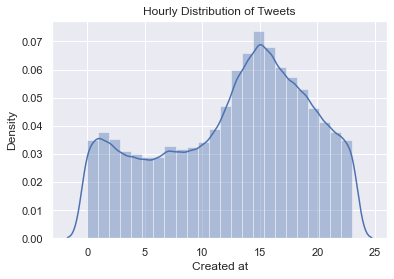

In [9]:
# Set the seaborn style
sns.set()

# Plot the histogram of hours
sns.distplot(tweets_processed["Created at"].dt.hour, bins=24)
plt.title("Hourly Distribution of Tweets")
plt.show()

In [10]:
# Print the value counts of Country column
print(tweets_processed["Country"].value_counts())

unknown    169734
US           6259
GB           2133
IN           1725
ZA           1416
            ...  
CZ              1
DZ              1
TC              1
YE              1
AL              1
Name: Country, Length: 155, dtype: int64


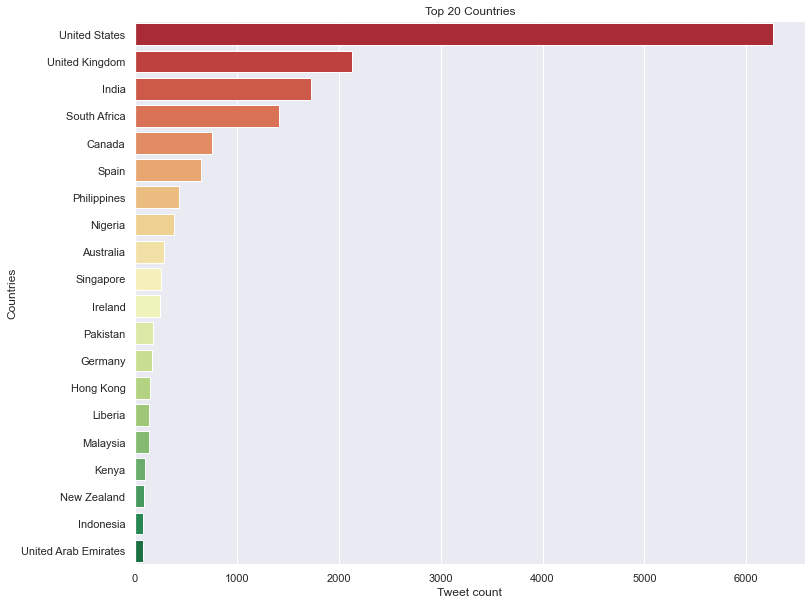

In [11]:
# We need to exclude unknowns
countries = tweets_processed[tweets_processed.Country!='unknown']

# Select the top 20 countries
top_countries = countries["Country"].value_counts(sort=True).head(20)

# Convert alpha2 country codes to country names and store in a list
country_fullnames = []
for alpha2 in top_countries.index:
    country_fullnames.append(pycountry.countries.get(alpha_2=alpha2).name)

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.barplot(y=country_fullnames,x=top_countries, orient="h", palette="RdYlGn")
plt.xlabel("Tweet count")
plt.ylabel("Countries")
plt.title("Top 20 Countries")
plt.show()

In [12]:
# Display the most popular tweets
display(tweets_processed.sort_values(by=["Favorites","Retweet-Count", ], axis=0, ascending=False)[["Content","Retweet-Count","Favorites"]].head(20))

,Content,Retweet-Count,Favorites
56343,"🤦🏿 UNESCO says 85% of children in sub-Saharan Africa are not learning.\n\nBut... if your children attend a religious or private school (e.g. a madrasa), it counts them as ""not learning.""\n\nAnd that's how official U.N. education statistics are produced. https://t.co/vKP0wM1ZYX",1189,16174
128163,kumulo dugo ko sa bagong content ng vincentiments. i get that online classes is not the ideal way to continue our education (trust me i hate the idea as well) pero entirely blaming teachers for doing what was asked of them is very wrong as well\n\n +++,2385,11457
33497,"Folks, the 12% VAT isn't just on Netflix, Lazada, etc. Pati po online trainings, e-learning facilities, webinars, payment facilities, conduits, so on will be under 12% VAT. Instead of pushing for online and contactless payments, mas gigipitin ang tao.",4070,9298
165022,Will start teaching online law school classes next week. 🤩\n\nGood luck to my students! 😈😇🤣,218,9204
89950,Q: Will there be special stages for the online concert?\nDahyun: Of course!\nTzuyu: There is,1171,8086
63534,You know what else schedule i'll be having on August..... my online class!! 🙃👏,1200,6260
77150,@MKBHD **Me attending my online class**\n\nMy family members behind me:- https://t.co/8sN3pF5NSc,536,6098
135669,"With this trying times caused by the pandemic, education has changed dramatically. As we transition to the usage of digital platforms for online learning, we aim to promote equal access of education. (1/5) https://t.co/76vFiFciWo",3266,5437
124797,The Georgia high school that became infamous for hallways crowded with unmasked students will temporarily go online after six students and three staffers tested positive COVID-19.\n\nThe district said it needs time to disinfect the school. https://t.co/nHK3O3rJAh,2094,4829
13907,1st week #distancelearning done. \n\nKey takeaways:\n\n1. Everything takes 3x longer.\n2. Tech is not a silver bullet. \n3. 1:5 = instructional min. : min. prep\n4. Kids are more polite than adults w/tech snafus. \n5. Use two screens.\n6. Expect the unexpected. \n7. Swear in your head.,885,4006


In [13]:
# Create a new DataFrame called frequencies
frequencies = pd.DataFrame(tfidf_matrix.sum(axis=0).T,index=vectorizer.get_feature_names(),columns=['total frequency'])

# Sort the words by frequency
frequencies.sort_values(by='total frequency',ascending=False, inplace=True)
# Display the most 20 frequent words
display(frequencies.head(20))

,total frequency
pay,2628.314122
help,2307.234513
new,1990.649529
like,1920.871740
free,1828.621878
time,1807.546880
need,1803.061707
first,1784.047974
kids,1775.916918
day,1729.569776


In [14]:
# Add polarities and subkectivities into the DataFrame by using TextBlob
tweets_processed["Polarity"] = tweets_processed["Processed"].apply(lambda word: TextBlob(word).sentiment.polarity)
tweets_processed["Subjectivity"] = tweets_processed["Processed"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display the Polarity and Subjectivity columns
display(tweets_processed[["Polarity","Subjectivity"]].head(10))

,Polarity,Subjectivity
0,0.500000,1.000000
1,0.000000,0.000000
2,0.143182,0.552273
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000000,0.041667
6,0.250000,0.250000
7,-0.025000,0.233333
8,0.136364,0.454545
9,0.000000,0.000000


In [15]:
# Define a function to classify polarities
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
tweets_processed["Label"] = tweets_processed["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(tweets_processed[["Label"]].head(10))

,Label
0,Positive
1,Neutral
2,Positive
3,Neutral
4,Neutral
5,Neutral
6,Positive
7,Negative
8,Positive
9,Neutral


In [16]:
# Print the value counts of the Label column
print(tweets_processed["Label"].value_counts())

Positive    100794
Neutral      57060
Negative     29198
Name: Label, dtype: int64


C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


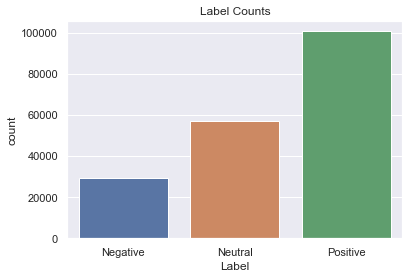

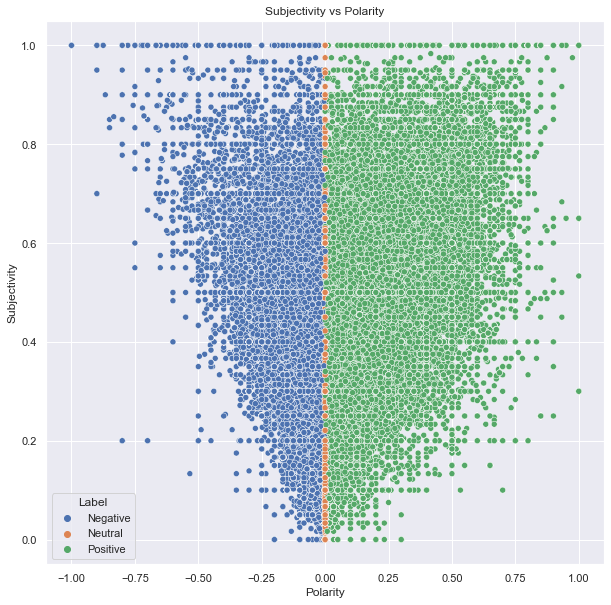

In [17]:
# Change the datatype as "category"
tweets_processed["Label"] = tweets_processed["Label"].astype("category")

# Visualize the Label counts
sns.countplot(tweets_processed["Label"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=tweets_processed)
plt.title("Subjectivity vs Polarity")
plt.show()

In [18]:
# Display the positive tweets
display(tweets_processed.sort_values(by=["Polarity","Favorites","Retweet-Count", ], axis=0, ascending=[False, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

# Display the negative tweets
display(tweets_processed.sort_values(by=["Polarity", "Favorites", "Retweet-Count"], axis=0, ascending=[True, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

,Content,Retweet-Count,Favorites,Polarity
79375,@jyrzyap Please tell your classmate. They are very grateful because they have all the equipments in online class. Despite of walang walang gamit ang Teacher niyo. He is doing his best to provide the information needed in your class. Not all Teachers can afford equipments for online class.,65,1286,1.0
84334,omgggg my best fren is in the same online class as me!!!!!,0,257,1.0
13538,Yes! I am making #STEM #STEAM kits for 786 Ss for #distancelearning! Why? Bc #kidsdeserveit! No #bigfrickinpackets! No #workshits! I want to be the best #Teachers for my Ss! @HRussell_STEAM 🎉 https://t.co/6DexYdQuz8,24,245,1.0
177093,I want best online teaching techniques and I will pay for it.\n\nI don't want my career to be idling on streets of MUMBAI.\n\nI am Indian Seafarer.,34,214,1.0
173038,"What works best in the classroom is what works best online, and that’s not passive learning. https://t.co/YJfmN5Qc3C via @slate",60,146,1.0
177947,Some awesome tips for teaching online via @kasal_finley! https://t.co/IzOng1pd6l,66,134,1.0
159192,My partner prepping their online class this semester. I have no idea what’s happening in this system but I’m impressed by their dedication. 😂 #AcademicTwitter https://t.co/nt6shZh8dm,6,133,1.0
38436,Learning Never Exhausts the Mind! Do you know which is the best Indian E-Learning App? Stay tuned to find out tomorrow (7th Aug 2020) at 12 Noon. #AatmaNirbharApp https://t.co/db4dUsZcai,31,118,1.0
160339,"@Kamogelo_MN I hope that we write online examinations even in 2nd semester .Some of us want law firms to be fighting for us once we finish our degrees😂😁 cheers to 10 distinctions ,2020 is our year .#unisa .y'all don't stand a chance against .Unisa produces Di best law attorneys in SA https://t.co/koJjQk0YsW",3,107,1.0
172629,"The #DistanceLearning Playbook book clubs with @CorwinPress for #teachers &amp; leaders start this week. Join @NancyFrey and me as we discuss research-based best teaching, assessment, &amp; planning practices for online classrooms. #edchat\nLearn more &amp; register: https://t.co/ooQZGpGrdW https://t.co/1ClpB9vTYD",35,102,1.0


,Content,Retweet-Count,Favorites,Polarity
59203,I made doodles of @ATiredShota’s mcyt apoc au cause online class is boring https://t.co/ys9A6tNp8q,12,218,-1.0
145606,I’m horrible at remembering to do online assignments so y’all pray for me this semester 🥺,28,66,-1.0
30682,"I want job tog. Ondahala iilonga aaholike,. This e-learning thing is boring mahn",2,47,-1.0
170877,Exams bhi leni hai... \nDuty bhi karvani hai... \nAur fees bhi leni hai.. \n\nAise kese chalega... \n\nAnd after all this insane things they are telling that we are teaching you through online classes!!! \n\n#saynotofees \n#nowornever,24,44,-1.0
81167,Online class is boring and all until one of your Saraiki classmates leave the mic opened,2,41,-1.0
59327,online class is soOO0 BORING,2,20,-1.0
73179,dafaq online class is so boring 😔,1,16,-1.0
34200,Teacher coming out against teaching. They are basically the only ones in favor of e-learning.\n\nThey are pathetic.,0,14,-1.0
151038,All my classes are online this semester and I might go insane 😀,0,14,-1.0
72973,drew an anime version of grim reaper during online class 😗✌️ https://t.co/NVuvwJhiPk,1,13,-1.0


Positive 

Country
US    1319
GB     227
IN     177
CA     126
ES      88
      ... 
CR       1
CU       1
CY       1
GU       1
SN       1
Name: Country, Length: 95, dtype: int64

Negative

Country
US    3343
GB    1424
ZA    1187
IN     897
CA     461
      ... 
BM       1
BJ       1
AQ       1
AG       1
YE       1
Name: Country, Length: 128, dtype: int64


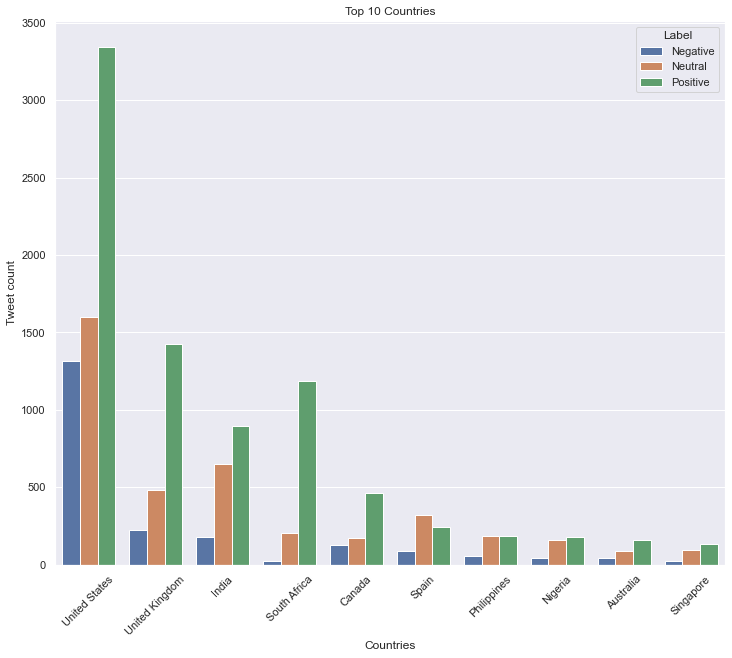

In [19]:
# Get the positive/negative counts by country
positives_by_country = tweets_processed[tweets_processed.Country!='unknown'].groupby("Label")["Country"].value_counts().Negative.sort_values(ascending=False)
negatives_by_country =tweets_processed[tweets_processed.Country!='unknown'].groupby("Label")["Country"].value_counts().Positive.sort_values(ascending=False)

# Print them out
print("Positive \n")
print(positives_by_country)
print("\nNegative\n")
print(negatives_by_country)

# Create a mask for top 1 countries (by tweets count)
mask = tweets_processed["Country"].isin(top_countries.index[:10]).values

# Create a new DataFrame only includes top10 country
top_20df = tweets_processed.iloc[mask,:]

# Visualize the top 20 countries
plt.figure(figsize=(12,10))
sns.countplot(x="Country", hue="Label", data=top_20df, order=top_20df["Country"].value_counts().index)
plt.xlabel("Countries")
locs, labels = plt.xticks()
plt.xticks(locs, country_fullnames[:10])
plt.xticks(rotation=45)
plt.ylabel("Tweet count")
plt.title("Top 10 Countries")
plt.show()

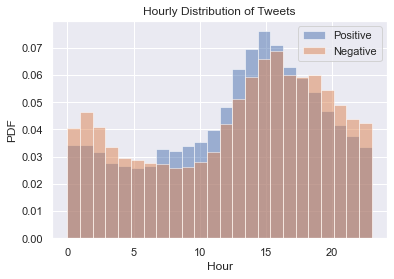

In [20]:
positive = tweets_processed.loc[tweets_processed.Label=="Positive"]["Created at"].dt.hour
negative = tweets_processed.loc[tweets_processed.Label=="Negative"]["Created at"].dt.hour

plt.hist(positive, alpha=0.5, bins=24, label="Positive", density=True)
plt.hist(negative, alpha=0.5, bins=24, label="Negative", density=True)
plt.xlabel("Hour")
plt.ylabel("PDF")
plt.title("Hourly Distribution of Tweets")
plt.legend(loc='upper right')
plt.show()

In [21]:
# Save the DataFrame
tweets_processed.to_csv("tweets_sentiments.csv")